### Imports

In [1]:
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
from keras import Sequential
from keras.applications import vgg16
from keras.layers import Dense, Flatten
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import adam_v2

# % matplotlib inline


### Constants

In [2]:
# Get train and test data from folder.
TRAIN_DIRECTORY = Path("data/AFD/AFD（Animal Face Dataset)/face images/Saimiri sciureus")

# Image Specifications
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CHANNELS = 3
IMAGE_DIMENSIONS = (IMG_HEIGHT, IMG_WIDTH)

# Cross Fold Validation
TEST_SIZE = 0.1  # 10% reserved for testing
NUMBER_FOLDS = 5  # k-fold CV
NUMBER_REPEATS = 1  # number of times to repeat k-fold cv

# MODEL PARAMETERS
BATCH_SIZE = 32  # This is keras default
NUM_EPOCHS = 30
LEARNING_RATE = 0.001

# Seed - for reproducibility
SEED = 123

### Load Data

In [3]:
def load_image_dataset(directory, img_width, img_height: (np.ndarray, np.ndarray)):
    X = []
    y = []

    for root, _, files in os.walk(directory):
        if not files:
            continue

        root = Path(root)
        dir_name = root.name

        for file in files:
            file_path = root / file
            assert file_path.is_file()

            img = plt.imread(str(file_path))
            if img is not None:
                # Add to the dataset
                res = cv2.resize(img, dsize=(img_width, img_height))
                X.append(res)
                y.append(int(dir_name))
            else:
                # indicate image was skipped
                print("Unable to read file '{}' Skipping".format(str(file_path.absolute())))

    print(len(X))
    print("First image")
    plt.imshow(X[1])

    # Convert to batch along the 0th axis
    X = np.stack(X, axis=0)
    y = np.stack(y, axis=0)

    return X, y

In [4]:
def investigate_class_distribution(y, number_folds):
    #TODO ensure that the plot is displayed in this function
    classes, counts = np.unique(y, return_counts=True)

    # TODO - add 1 for false-positives (not a monkey), 1 for previously unseen individuals
    number_classes = len(classes)

    too_few = np.nonzero(np.where(counts < number_folds, classes, 0))
    print(too_few)

    plt.hist(counts)
    plt.ylabel("Instances")
    plt.xlabel("Class")
    plt.title("Class Frequency in Training Set")
    plt.show()

    return number_classes

In [5]:
def get_stratified_train_test_split(X, y, test_size, seed):
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,
                                                                                y,
                                                                                shuffle=True,
                                                                                test_size=test_size,
                                                                                random_state=seed,
                                                                                stratify=y
                                                                                )

    print("Train size: ", len(X_train))
    print("Test size: ", len(X_test))

    return X_train, X_test, y_train, y_test

### Model Architecture

In [6]:
class VGGModel:
    def __init__(self, epochs, number_classes):
        self.model = self.make_model(number_classes=number_classes)
        self.histogram = None
        self.epochs = epochs

    @staticmethod
    def make_model(number_classes):
        # See here for implementation https://keras.io/api/applications/vgg/#vgg16-function
        vgg_model = vgg16.VGG16(
            include_top=False,
            weights="imagenet",
            input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS),
            pooling='avg',  # Global average pooling applied.
        )
        # Freeze all layers
        vgg_model.trainable = False
        fully_connected_output = Sequential()

        # Add dense layers to perform prediction
        fully_connected_output.add(Flatten())
        fully_connected_output.add(Dense(units=4096, activation="relu"))
        fully_connected_output.add(Dense(units=4096, activation="relu"))
        fully_connected_output.add(Dense(units=number_classes, activation="softmax"))

        # Create final model
        return Sequential([vgg_model, fully_connected_output])

    def compile(self):
        optimizer = adam_v2.Adam(learning_rate=LEARNING_RATE)

        # sparse as Y values are stored as integers (0-42), rather than one-hot encoded (i.e. 3 class, [1,0,0], [0,1,0], [0,0,1])
        loss = sparse_categorical_crossentropy

        self.model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    # Pre-Process Data for VGG
    @staticmethod
    def pre_process(X_unprocessed):
        # is performing in slices
        return np.apply_along_axis(func1d=lambda x: vgg16.preprocess_input(x), axis=0, arr=X_unprocessed)

    def fit(self, raw_X, raw_y):
        preprocessed_X = self.pre_process(raw_X)
        self.histogram = self.model.fit(
            x=preprocessed_X,
            y=raw_y,
            epochs=self.epochs,
            verbose=True)

    def evaluate(self, X_eval, y_eval):
        preprocessed_X = self.pre_process(X_eval)
        return self.model.evaluate(preprocessed_X, y_eval)

    def predict(self, X_pred):
        preprocessed_X = self.pre_process(X_pred)
        return self.model.predict(X_pred)

    def plot_results(self):
        self.plot_accuracy()
        self.plot_loss()

    def plot_accuracy(self):
        plt.plot(self.histogram.history['accuracy'])
        plt.title("Model Accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.show()

    def plot_loss(self):
        plt.plot(self.histogram.history['loss'])
        plt.title("Model Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.show()

In [7]:
def train_and_eval_model(wrapped_keras_model, X_train, y_train, X_val, y_val: np.ndarray):
    """
    Trains and Evaluates the input wrapped Keras model.
    :param wrapped_keras_model: The model object should implement the compile, fit, and
    evaluate methods.
    :param X_train: The training dataset to be used, as a 4d np array
    :param y_train: The training dataset labels to be used. Should be sparsely encoded.
    :param X_val: The validation dataset to be used, as a 4d np array
    :param y_val: The validation dataset labels to be used. Should be sparsely encoded.
    :return: The score (typically loss & accuracy) of the model of the fitted model on the validation dataset
    """
    wrapped_keras_model.compile()

    # Could split into batches here.
    print("Fitting Model:")
    wrapped_keras_model.fit(X_train, y_train)

    print()
    print("Evaluating Model")
    wrapped_keras_model_score = wrapped_keras_model.evaluate(X_val, y_val)

    print()
    print("Model Score")
    metric_names = wrapped_keras_model.model.metrics_names
    for j in range(len(metric_names)):
        print("- {}: {:.2f}".format(metric_names[j], wrapped_keras_model_score[j]))

    wrapped_keras_model.plot_results()

    return wrapped_keras_model_score

In [8]:
def repeated_stratified_k_fold(num_repeats, num_folds, seed, X, y, number_classes):
    rskf = sklearn.model_selection.RepeatedStratifiedKFold(
        n_repeats=num_repeats,
        n_splits=num_folds,
        random_state=seed,
    )

    scores = np.zeros(shape=(rskf.get_n_splits(X, y), 2))

    for i, (train_index, test_index) in enumerate(rskf.split(X, y)):
        print("*** Performing Repeat {}/{} Fold {}/{}***".format(round(i / (NUMBER_FOLDS + 1)) + 1,
                                                                 NUMBER_REPEATS,
                                                                 (i + 1) % (NUMBER_FOLDS + 1),
                                                                 NUMBER_FOLDS), )
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        model = VGGModel(epochs=NUM_EPOCHS, number_classes=number_classes)
        score = train_and_eval_model(wrapped_keras_model=model,
                                     X_train=X_train,
                                     y_train=y_train,
                                     X_val=X_val,
                                     y_val=y_val)
        scores[i, 0] = score[0]
        scores[i, 1] = score[1]

        print("\n\n", end="")

    return scores

#### Train Final Model using All Data and Compare to Test Set

In [9]:
def train_and_evaluate_full_model(X_train, X_test, y_train, y_test, number_classes):
    final_model = VGGModel(epochs=NUM_EPOCHS, number_classes=number_classes)
    test_score = train_and_eval_model(wrapped_keras_model=final_model,
                                      X_train=X_train,
                                      y_train=y_train,
                                      X_val=X_test,
                                      y_val=y_test)

    return final_model, test_score

504
First image


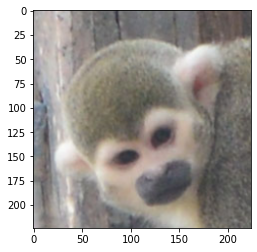

In [10]:
X, y = load_image_dataset(directory=TRAIN_DIRECTORY, img_width=IMG_WIDTH, img_height=IMG_HEIGHT)

(array([ 6,  9, 10, 22, 28, 31, 34], dtype=int64),)


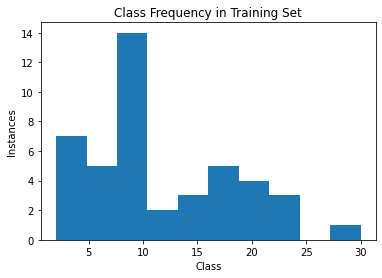

In [11]:
number_classes = investigate_class_distribution(y=y, number_folds=NUMBER_FOLDS)


In [12]:
X_train, X_test, y_train, y_test = get_stratified_train_test_split(X=X, y=y,
                                                                   test_size=TEST_SIZE,
                                                                   seed=SEED)

Train size:  453
Test size:  51


*** Performing Repeat 1/1 Fold 1/5***


E:\Compsci 760 - Animal Indentification\python\venv\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


NUmber Classes 44
Fitting Model:
Epoch 1/30
12/12 [==============================] - 12s 255ms/step - loss: 16.9212 - accuracy: 0.0359

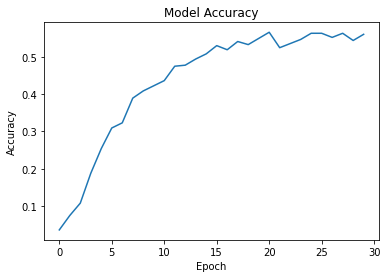

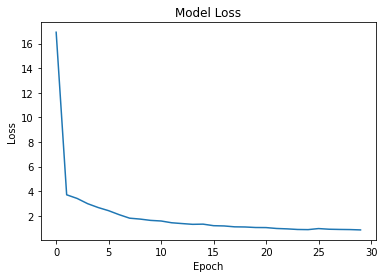



*** Performing Repeat 1/1 Fold 2/5***
NUmber Classes 44
Fitting Model:
Epoch 1/30
12/12 [==============================] - 2s 99ms/step - loss: 16.8892 - accuracy: 0.0276

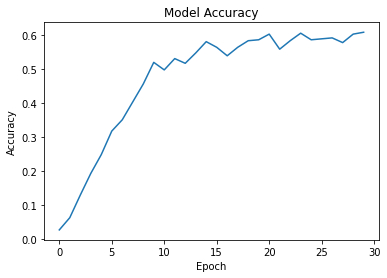

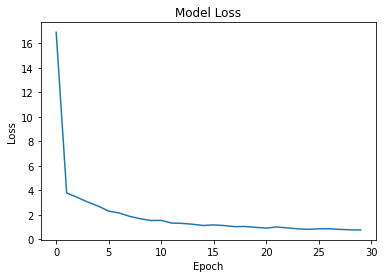



*** Performing Repeat 1/1 Fold 3/5***
NUmber Classes 44
Fitting Model:
Epoch 1/30
12/12 [==============================] - 2s 101ms/step - loss: 20.8978 - accuracy: 0.0276

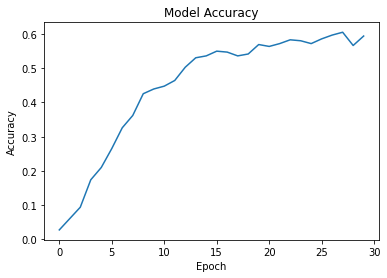

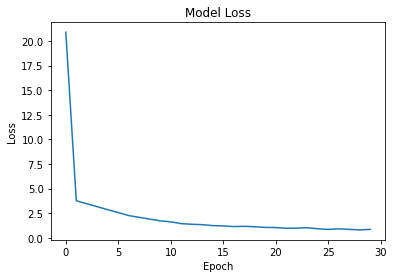



*** Performing Repeat 1/1 Fold 4/5***
NUmber Classes 44
Fitting Model:
Epoch 1/30
12/12 [==============================] - 4s 277ms/step - loss: 18.8426 - accuracy: 0.0551

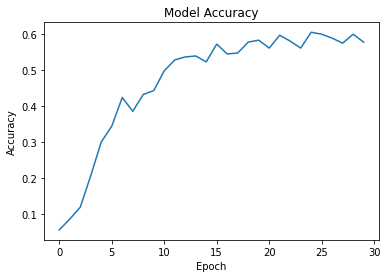

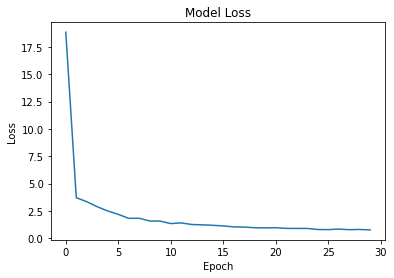



*** Performing Repeat 2/1 Fold 5/5***
NUmber Classes 44
Fitting Model:
Epoch 1/30
12/12 [==============================] - 2s 101ms/step - loss: 17.8519 - accuracy: 0.0331

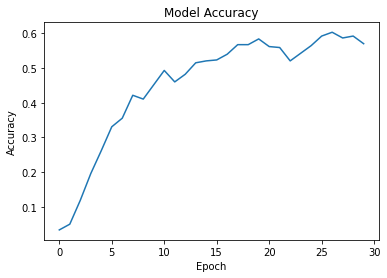

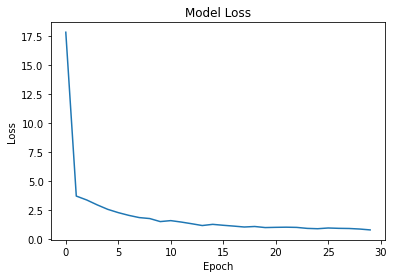

In [13]:
rskf_scores = repeated_stratified_k_fold(X=X_train, y=y_train,
                                         number_classes=number_classes,
                                         num_repeats=NUMBER_REPEATS,
                                         num_folds=NUMBER_FOLDS,
                                         seed=SEED)

In [14]:
cross_validated_score = np.average(rskf_scores, axis=0)

print("Average Loss: {:.2f}".format(cross_validated_score[0]))
print("Average Accuracy: {:.2f}%".format(cross_validated_score[1] * 100))

Average Loss: 7.78
Average Accuracy: 3.75%


Testing Model on Full Dataset:
NUmber Classes 44
Fitting Model:
Epoch 1/30
15/15 [==============================] - 3s 169ms/step - loss: 15.3428 - accuracy: 0.0419

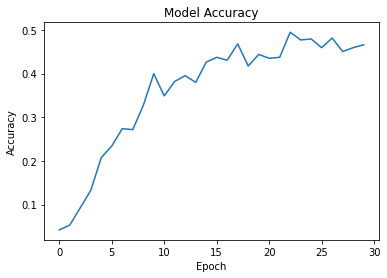

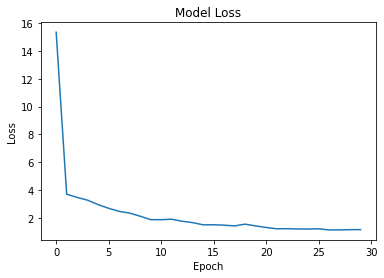

Full Training Dataset Average Loss: 6.93
Full Training Dataset Average Accuracy: 1.96%


In [15]:
print("Testing Model on Full Dataset:")
final_model, final_model_score = train_and_evaluate_full_model(X_train=X_train,
                                                               y_train=y_train,
                                                               X_test=X_test,
                                                               y_test=y_test,
                                                               number_classes=number_classes)

print("Full Training Dataset Average Loss: {:.2f}".format(final_model_score[0]))
print("Full Training Dataset Average Accuracy: {:.2f}%".format(final_model_score[1] * 100))